In [41]:
%run CompareGPUOceanOpendriftParcels.ipynb

In [37]:
source_url =  ['/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc', 
               '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc', 
               '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc'
              ]
purl = '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/*'
url = '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'
#Save X, Y(dimensions) from netcdf file from norkyst800
ncfile = Dataset(url)
X = ncfile.variables['X'][:]
Y = ncfile.variables['Y'][:]
ncfile.close()

#Create OpendriftObject with norkys data to access coordinate-change lonlat2xy
reader_norkyst = reader_netCDF_CF_generic.Reader(url)
o = OceanDrift(loglevel=50)
o.add_reader(reader_norkyst, variables=['x_sea_water_velocity', 'y_sea_water_velocity'])

#lon, lat = 14.1,69.4
lon, lat = 4.9, 60.0
#lon, lat = 9.2, 63.9
hours = 71

10:36:17 INFO: Opening dataset: /home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc
10:36:17 INFO: Opening file with Dataset


In [38]:
o1 = simulate_opendrift(source_url, lat, lon, 0.0, True, hours) #no wind, average velocity

will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  self.Dataset = xr.open_mfdataset(filename)

to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,

10:36:19 INFO: OpenDriftSimulation initialised (version 1.2.3)
10:36:19 INFO: Config validation OK
10:36:19 INFO: Adding a dynamical landmask with max. priority based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
10:36:22 INFO: Using existing reader for land_binary_mask
10:36:22 INFO: All points are in ocean
10:36:22 INFO: 2019-07-16 00:00:00 - step 1 of

10:39:45 INFO: 2019-07-16 06:30:00 - step 79 of 852 - 1 active elements (0 deactivated)
10:39:45 INFO: 2019-07-16 06:35:00 - step 80 of 852 - 1 active elements (0 deactivated)
10:39:45 INFO: 2019-07-16 06:40:00 - step 81 of 852 - 1 active elements (0 deactivated)
10:39:45 INFO: 2019-07-16 06:45:00 - step 82 of 852 - 1 active elements (0 deactivated)
10:39:45 INFO: 2019-07-16 06:50:00 - step 83 of 852 - 1 active elements (0 deactivated)
10:39:45 INFO: 2019-07-16 06:55:00 - step 84 of 852 - 1 active elements (0 deactivated)
10:39:45 INFO: 2019-07-16 07:00:00 - step 85 of 852 - 1 active elements (0 deactivated)
10:40:12 INFO: 2019-07-16 07:05:00 - step 86 of 852 - 1 active elements (0 deactivated)
10:40:12 INFO: 2019-07-16 07:10:00 - step 87 of 852 - 1 active elements (0 deactivated)
10:40:12 INFO: 2019-07-16 07:15:00 - step 88 of 852 - 1 active elements (0 deactivated)
10:40:12 INFO: 2019-07-16 07:20:00 - step 89 of 852 - 1 active elements (0 deactivated)
10:40:12 INFO: 2019-07-16 07:25:

10:43:10 INFO: 2019-07-16 14:15:00 - step 172 of 852 - 1 active elements (0 deactivated)
10:43:10 INFO: 2019-07-16 14:20:00 - step 173 of 852 - 1 active elements (0 deactivated)
10:43:10 INFO: 2019-07-16 14:25:00 - step 174 of 852 - 1 active elements (0 deactivated)
10:43:10 INFO: 2019-07-16 14:30:00 - step 175 of 852 - 1 active elements (0 deactivated)
10:43:10 INFO: 2019-07-16 14:35:00 - step 176 of 852 - 1 active elements (0 deactivated)
10:43:10 INFO: 2019-07-16 14:40:00 - step 177 of 852 - 1 active elements (0 deactivated)
10:43:11 INFO: 2019-07-16 14:45:00 - step 178 of 852 - 1 active elements (0 deactivated)
10:43:11 INFO: 2019-07-16 14:50:00 - step 179 of 852 - 1 active elements (0 deactivated)
10:43:11 INFO: 2019-07-16 14:55:00 - step 180 of 852 - 1 active elements (0 deactivated)
10:43:11 INFO: 2019-07-16 15:00:00 - step 181 of 852 - 1 active elements (0 deactivated)
10:43:38 INFO: 2019-07-16 15:05:00 - step 182 of 852 - 1 active elements (0 deactivated)
10:43:38 INFO: 2019-0

10:46:17 INFO: 2019-07-16 22:00:00 - step 265 of 852 - 1 active elements (0 deactivated)
10:46:41 INFO: 2019-07-16 22:05:00 - step 266 of 852 - 1 active elements (0 deactivated)
10:46:41 INFO: 2019-07-16 22:10:00 - step 267 of 852 - 1 active elements (0 deactivated)
10:46:41 INFO: 2019-07-16 22:15:00 - step 268 of 852 - 1 active elements (0 deactivated)
10:46:41 INFO: 2019-07-16 22:20:00 - step 269 of 852 - 1 active elements (0 deactivated)
10:46:41 INFO: 2019-07-16 22:25:00 - step 270 of 852 - 1 active elements (0 deactivated)
10:46:41 INFO: 2019-07-16 22:30:00 - step 271 of 852 - 1 active elements (0 deactivated)
10:46:41 INFO: 2019-07-16 22:35:00 - step 272 of 852 - 1 active elements (0 deactivated)
10:46:42 INFO: 2019-07-16 22:40:00 - step 273 of 852 - 1 active elements (0 deactivated)
10:46:42 INFO: 2019-07-16 22:45:00 - step 274 of 852 - 1 active elements (0 deactivated)
10:46:42 INFO: 2019-07-16 22:50:00 - step 275 of 852 - 1 active elements (0 deactivated)
10:46:42 INFO: 2019-0

10:49:38 INFO: 2019-07-17 05:45:00 - step 358 of 852 - 1 active elements (0 deactivated)
10:49:38 INFO: 2019-07-17 05:50:00 - step 359 of 852 - 1 active elements (0 deactivated)
10:49:38 INFO: 2019-07-17 05:55:00 - step 360 of 852 - 1 active elements (0 deactivated)
10:49:38 INFO: 2019-07-17 06:00:00 - step 361 of 852 - 1 active elements (0 deactivated)
10:50:03 INFO: 2019-07-17 06:05:00 - step 362 of 852 - 1 active elements (0 deactivated)
10:50:03 INFO: 2019-07-17 06:10:00 - step 363 of 852 - 1 active elements (0 deactivated)
10:50:03 INFO: 2019-07-17 06:15:00 - step 364 of 852 - 1 active elements (0 deactivated)
10:50:03 INFO: 2019-07-17 06:20:00 - step 365 of 852 - 1 active elements (0 deactivated)
10:50:03 INFO: 2019-07-17 06:25:00 - step 366 of 852 - 1 active elements (0 deactivated)
10:50:03 INFO: 2019-07-17 06:30:00 - step 367 of 852 - 1 active elements (0 deactivated)
10:50:03 INFO: 2019-07-17 06:35:00 - step 368 of 852 - 1 active elements (0 deactivated)
10:50:03 INFO: 2019-0

10:53:02 INFO: 2019-07-17 13:30:00 - step 451 of 852 - 1 active elements (0 deactivated)
10:53:02 INFO: 2019-07-17 13:35:00 - step 452 of 852 - 1 active elements (0 deactivated)
10:53:02 INFO: 2019-07-17 13:40:00 - step 453 of 852 - 1 active elements (0 deactivated)
10:53:02 INFO: 2019-07-17 13:45:00 - step 454 of 852 - 1 active elements (0 deactivated)
10:53:02 INFO: 2019-07-17 13:50:00 - step 455 of 852 - 1 active elements (0 deactivated)
10:53:02 INFO: 2019-07-17 13:55:00 - step 456 of 852 - 1 active elements (0 deactivated)
10:53:02 INFO: 2019-07-17 14:00:00 - step 457 of 852 - 1 active elements (0 deactivated)
10:53:28 INFO: 2019-07-17 14:05:00 - step 458 of 852 - 1 active elements (0 deactivated)
10:53:28 INFO: 2019-07-17 14:10:00 - step 459 of 852 - 1 active elements (0 deactivated)
10:53:28 INFO: 2019-07-17 14:15:00 - step 460 of 852 - 1 active elements (0 deactivated)
10:53:28 INFO: 2019-07-17 14:20:00 - step 461 of 852 - 1 active elements (0 deactivated)
10:53:28 INFO: 2019-0

10:56:22 INFO: 2019-07-17 21:15:00 - step 544 of 852 - 1 active elements (0 deactivated)
10:56:22 INFO: 2019-07-17 21:20:00 - step 545 of 852 - 1 active elements (0 deactivated)
10:56:22 INFO: 2019-07-17 21:25:00 - step 546 of 852 - 1 active elements (0 deactivated)
10:56:22 INFO: 2019-07-17 21:30:00 - step 547 of 852 - 1 active elements (0 deactivated)
10:56:22 INFO: 2019-07-17 21:35:00 - step 548 of 852 - 1 active elements (0 deactivated)
10:56:22 INFO: 2019-07-17 21:40:00 - step 549 of 852 - 1 active elements (0 deactivated)
10:56:22 INFO: 2019-07-17 21:45:00 - step 550 of 852 - 1 active elements (0 deactivated)
10:56:22 INFO: 2019-07-17 21:50:00 - step 551 of 852 - 1 active elements (0 deactivated)
10:56:22 INFO: 2019-07-17 21:55:00 - step 552 of 852 - 1 active elements (0 deactivated)
10:56:22 INFO: 2019-07-17 22:00:00 - step 553 of 852 - 1 active elements (0 deactivated)
10:56:48 INFO: 2019-07-17 22:05:00 - step 554 of 852 - 1 active elements (0 deactivated)
10:56:48 INFO: 2019-0

10:59:19 INFO: 2019-07-18 05:00:00 - step 637 of 852 - 1 active elements (0 deactivated)
10:59:42 INFO: 2019-07-18 05:05:00 - step 638 of 852 - 1 active elements (0 deactivated)
10:59:42 INFO: 2019-07-18 05:10:00 - step 639 of 852 - 1 active elements (0 deactivated)
10:59:42 INFO: 2019-07-18 05:15:00 - step 640 of 852 - 1 active elements (0 deactivated)
10:59:42 INFO: 2019-07-18 05:20:00 - step 641 of 852 - 1 active elements (0 deactivated)
10:59:42 INFO: 2019-07-18 05:25:00 - step 642 of 852 - 1 active elements (0 deactivated)
10:59:42 INFO: 2019-07-18 05:30:00 - step 643 of 852 - 1 active elements (0 deactivated)
10:59:42 INFO: 2019-07-18 05:35:00 - step 644 of 852 - 1 active elements (0 deactivated)
10:59:42 INFO: 2019-07-18 05:40:00 - step 645 of 852 - 1 active elements (0 deactivated)
10:59:42 INFO: 2019-07-18 05:45:00 - step 646 of 852 - 1 active elements (0 deactivated)
10:59:42 INFO: 2019-07-18 05:50:00 - step 647 of 852 - 1 active elements (0 deactivated)
10:59:42 INFO: 2019-0

11:02:39 INFO: 2019-07-18 12:45:00 - step 730 of 852 - 1 active elements (0 deactivated)
11:02:39 INFO: 2019-07-18 12:50:00 - step 731 of 852 - 1 active elements (0 deactivated)
11:02:39 INFO: 2019-07-18 12:55:00 - step 732 of 852 - 1 active elements (0 deactivated)
11:02:39 INFO: 2019-07-18 13:00:00 - step 733 of 852 - 1 active elements (0 deactivated)
11:03:04 INFO: 2019-07-18 13:05:00 - step 734 of 852 - 1 active elements (0 deactivated)
11:03:04 INFO: 2019-07-18 13:10:00 - step 735 of 852 - 1 active elements (0 deactivated)
11:03:04 INFO: 2019-07-18 13:15:00 - step 736 of 852 - 1 active elements (0 deactivated)
11:03:04 INFO: 2019-07-18 13:20:00 - step 737 of 852 - 1 active elements (0 deactivated)
11:03:04 INFO: 2019-07-18 13:25:00 - step 738 of 852 - 1 active elements (0 deactivated)
11:03:04 INFO: 2019-07-18 13:30:00 - step 739 of 852 - 1 active elements (0 deactivated)
11:03:04 INFO: 2019-07-18 13:35:00 - step 740 of 852 - 1 active elements (0 deactivated)
11:03:04 INFO: 2019-0

11:06:01 INFO: 2019-07-18 20:30:00 - step 823 of 852 - 1 active elements (0 deactivated)
11:06:01 INFO: 2019-07-18 20:35:00 - step 824 of 852 - 1 active elements (0 deactivated)
11:06:01 INFO: 2019-07-18 20:40:00 - step 825 of 852 - 1 active elements (0 deactivated)
11:06:01 INFO: 2019-07-18 20:45:00 - step 826 of 852 - 1 active elements (0 deactivated)
11:06:01 INFO: 2019-07-18 20:50:00 - step 827 of 852 - 1 active elements (0 deactivated)
11:06:01 INFO: 2019-07-18 20:55:00 - step 828 of 852 - 1 active elements (0 deactivated)
11:06:01 INFO: 2019-07-18 21:00:00 - step 829 of 852 - 1 active elements (0 deactivated)
11:06:27 INFO: 2019-07-18 21:05:00 - step 830 of 852 - 1 active elements (0 deactivated)
11:06:27 INFO: 2019-07-18 21:10:00 - step 831 of 852 - 1 active elements (0 deactivated)
11:06:27 INFO: 2019-07-18 21:15:00 - step 832 of 852 - 1 active elements (0 deactivated)
11:06:27 INFO: 2019-07-18 21:20:00 - step 833 of 852 - 1 active elements (0 deactivated)
11:06:27 INFO: 2019-0

In [39]:
initx, inity, x0,x1, y0,y1 = initlonlat2initgpuocean(o, X, Y, lon, lat, 50,50)
o1obs = opendriftObj2gpuoceanObs(o1, X, Y, x0, x1,y0,y1)

316.0
[[38486.548484478146 38394.19294445403 38302.955257653724
  38213.24337477237 38124.68304334534 38039.98404956749
  37959.928685315885 37885.673552553635 37816.47012638813
  37754.010709936265 37699.97638791846 37653.99290167075
  37616.84251782484 37588.27872827649 37569.664294376504
  37560.965605905745 37561.785949576646 37571.94602643931
  37590.85861797165 37618.5237434078 37654.544713077135 37697.5700142947
  37745.057976806536 37797.42776006227 37854.66819234099
  37913.53380100755 37971.18701475486 38027.639044914395
  38082.50438793283 38133.7164553171 38177.6329862806 38214.650664998684
  38244.350346508436 38265.597877479624 38276.46567541268
  38277.339211434126 38267.832930958364 38248.197875368875
  38218.34437535051 38179.020988820586 38129.082303138915
  38070.77411221992 38005.57119266223 37932.70243331045 37853.32430762332
  37768.59330278495 37680.45937780617 37589.72715332592 37495.59193198709
  37400.56852631271 34926.65531381732 34910.760544314515
  34886.00

In [42]:
domain = [x0,x1,y0,y1]
gpuobs = simulate_gpuocean_deterministic(source_url, domain, initx, inity, erode_land = 1, sim_args = sim_args, 
                                         outfolder = None, forecast_duration = hours )

'0% [##############################] 100%. Total: 3m 17s, elapsed: 3m 17s, remaining: 0s'

In [43]:
simulate_parcels(purl, 'parcels_ex.nc', lat,lon,0.0,True,hours) #no wind, average velocity

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/564d62727fe15568ca0d31a36dda9c15_0.so
INFO:parcels.tools.loggers:Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/564d62727fe15568ca0d31a36dda9c15_0.so
INFO: Temporary output files are stored in out-BLHSTUEZ.
INFO:parcels.tools.loggers:Temporary output files are stored in out-BLHSTUEZ.
INFO: You can use "parcels_convert_npydir_to_netcdf out-BLHSTUEZ" to convert these to a NetCDF file during the run.
INFO:parcels.tools.loggers:You can use "parcels_convert_npydir_to_netcdf out-BLHSTUEZ" to convert these to a NetCDF file during the run.
100% (255600.0 of 255600.0) |############| Elapsed Time: 0:00:25 Time:  0:00:25


In [44]:
pobs = parcelsFile2gpuoceanObs('parcels_ex.nc', o, X, Y, x0, x1, y0,y1)

In [51]:
gpuobs2 = simulate_gpuocean_deterministic(source_url, domain, initx, inity, rescale = 4, erode_land = 1, sim_args = sim_args,
                                          outfolder = None, forecast_duration = hours )

'0% [##############################] 100%. Total: 12m 59s, elapsed: 12m 59s, remaining: 0s'

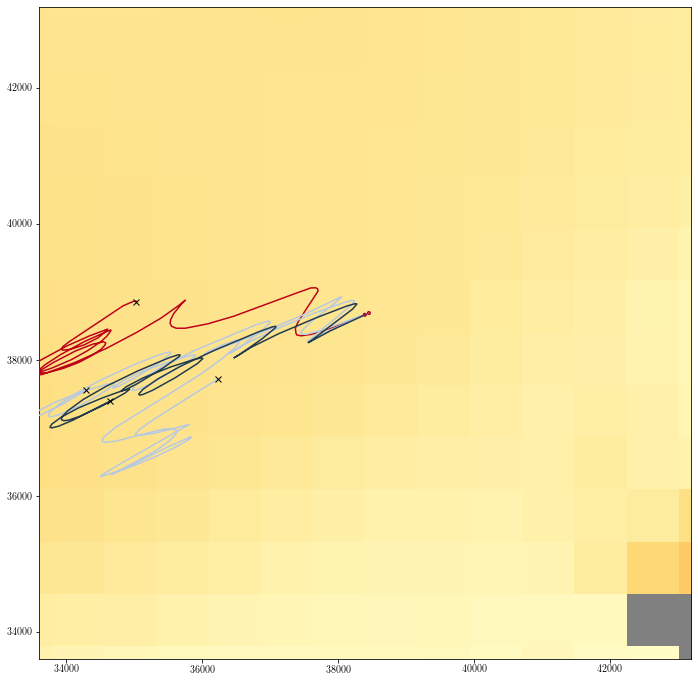

In [50]:
%matplotlib inline
colors= ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark blue grey']
ax = createForecastCanvas(gpuobs,background = True, url = url, domain = domain, zoom = 8)
plotAllDrifters(gpuobs, ax= ax, end = hours, color_id = 0)
plotAllDrifters(gpuobs2, ax= ax, end = hours, color_id = 1) #Hmm.....strange, må teste flere eksempler
plotAllDrifters(pobs, ax = ax, end = hours, color_id = 1)
plotAllDrifters(o1obs, ax=ax, end = hours, color_id = 2)
#REMARK: Different landmask here and in Opendrift. Opendrift is actually stranded.